## Importing Modules

In [2]:
#Importing Necessary Modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split


## Data Preprocessing 

In [3]:
attrition_df = pd.read_csv('HR-Employee-Attrition.csv')
attrition_df = pd.get_dummies(attrition_df) #Convert categorical columns to discrete numbers
attrition_df = attrition_df.drop(['Attrition_No','Gender_Female','OverTime_No','EmployeeCount',
                                  'StandardHours','Over18_Y',
                                  'EmployeeNumber'],axis=1) #Dropping useless columns (Same value, ID, Extra Category)

attrition_df = attrition_df.rename(columns={"Attrition_Yes": "Attrition", "OverTime_Yes": "OverTime"}) 
#Because converted categorical columns change names, change binary categories back to their original names

y= attrition_df['Attrition']
X=attrition_df.drop('Attrition',axis=1) #Separate data into X and Y columns

non_numeric_cols = ['JobLevel','StockOptionLevel','BusinessTravel_Non-Travel','BusinessTravel_Travel_Frequently',
                    'BusinessTravel_Travel_Rarely','Department_Human Resources','Department_Research & Development',
                    'Department_Sales','EducationField_Human Resources','EducationField_Life Sciences',
                    'EducationField_Marketing','EducationField_Medical','EducationField_Other',
                    'EducationField_Technical Degree','Gender_Male','JobRole_Healthcare Representative',
                    'JobRole_Manufacturing Director','JobRole_Human Resources','JobRole_Laboratory Technician',
                    'JobRole_Manager','JobRole_Research Director','JobRole_Research Scientist','JobRole_Sales Executive',
                    'JobRole_Sales Representative','MaritalStatus_Divorced','MaritalStatus_Married','MaritalStatus_Single',
                    'OverTime','Education','EnvironmentSatisfaction','JobInvolvement','JobSatisfaction','PerformanceRating',
                    'RelationshipSatisfaction','WorkLifeBalance'] #Categorical Columns

numeric_df = attrition_df.drop(non_numeric_cols, axis=1) #Dataframe with only numerical columns, including Y-column 'Attrition'

print(numeric_df.columns)



Index(['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Attrition'],
      dtype='object')


## Experimenting with Correlation

to_drop columns:  ['JobLevel', 'MonthlyIncome', 'PercentSalaryHike', 'YearsAtCompany', 'YearsInCurrentRole', 'BusinessTravel_Travel_Frequently', 'Department_Human Resources', 'Department_Research & Development', 'Department_Sales']


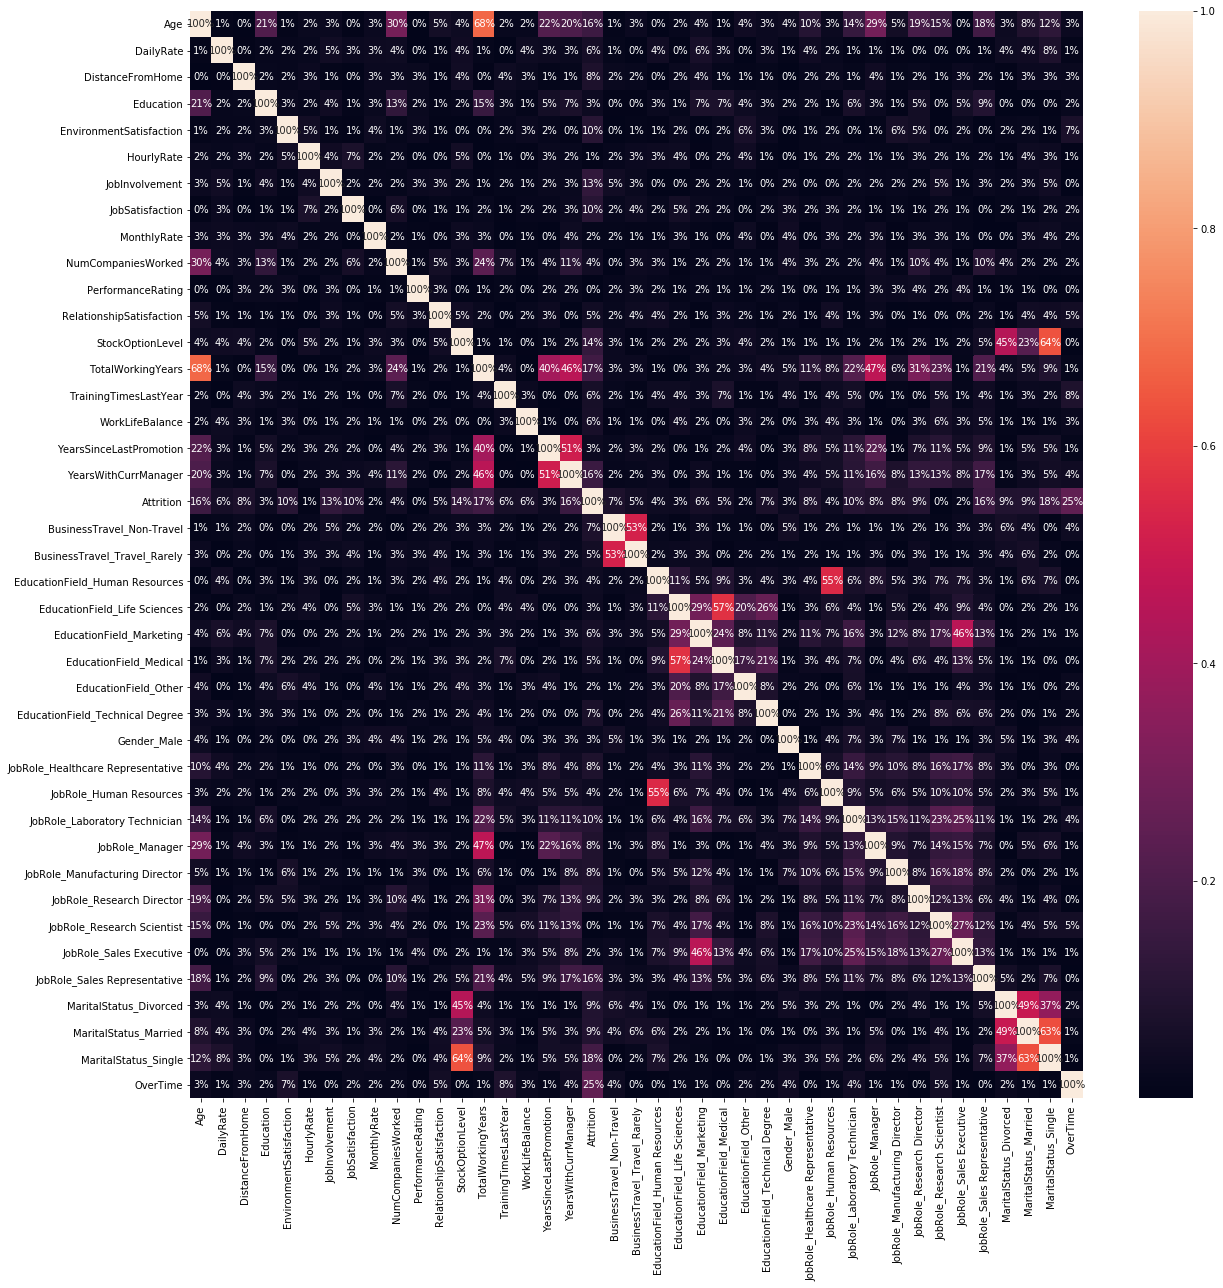

In [4]:
corr_mask = np.triu(np.ones_like(attrition_df.corr(), dtype=bool))
tri_df = attrition_df.corr().abs().mask(corr_mask)
plt.figure(figsize=(20,20))
#sns.heatmap(attrition_df.corr().abs(),mask=corr_mask,annot=True,fmt='.0%')
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.7)]
print('to_drop columns: ', to_drop)
df_exp = attrition_df.drop(to_drop, axis=1)
df_exp.corr()
sns.heatmap(df_exp.corr().abs(),annot=True,fmt='.0%')

X= df_exp.drop('Attrition',axis=1)
y=df_exp['Attrition']

## Naive Bayes Construction and Model Evaluation 

## Random Forest Construction and Model Evaluation 

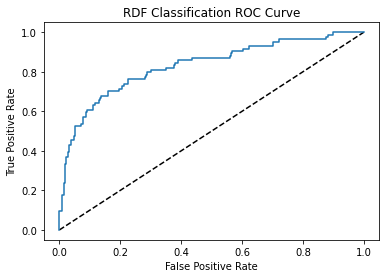

auc_score:  0.8294317727090837


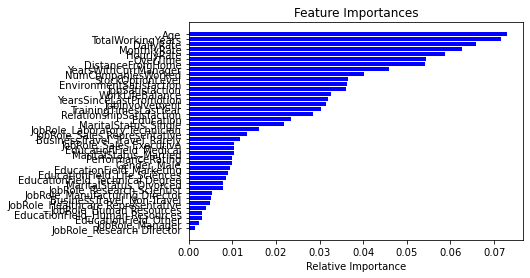

[[354   3]
 [ 74  10]]
accuracy:  0.8253968253968254
recall:  0.8271028037383178
FPR:  0.23076923076923078
cv_accuracy_score:  0.8581096516276414


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
RDF = RandomForestClassifier(random_state=123, max_depth=10, n_estimators=500)
RDF.fit(X_train, y_train)
y_pred = RDF.predict(X_test)
y_prob = RDF.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RDF Classification ROC Curve')
plt.show()
print('auc_score: ', roc_auc_score(y_test, y_prob))

features = X.columns
importances = RDF.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('accuracy: ', (cf_matrix[0,0]+cf_matrix[1,1])/np.sum(cf_matrix))
print('recall: ', cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[1,0]))
print('FPR: ', cf_matrix[0,1]/(cf_matrix[0,1]+cf_matrix[1,1]))

k_fold = KFold(n_splits=10, shuffle=True, random_state=123)
score = cross_val_score(RDF, X_train, y_train, cv=k_fold, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

## Hyperparameter Tuning using GridSearchCV

In [18]:
#Hyper-parameter Tuning

#random_grid = {'n_estimators': [100, 200, 300, 500],
               #'max_depth': [5, 10, 20, 30]}

#grid_search = GridSearchCV(estimator = RDF, param_grid = random_grid, 
                          #cv = k_fold, verbose = 1)

#grid_search.fit(X_train, y_train)
#print(print(grid_search.best_params_))

## Using reduced columns based on feature importance to construct a new RDFR Model

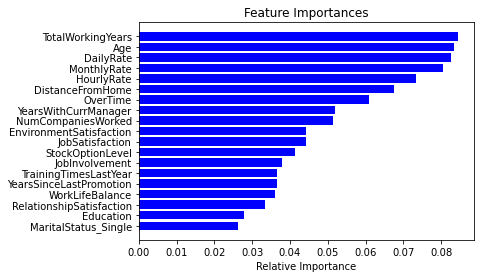

[[353   4]
 [ 73  11]]
accuracy:  0.8253968253968254
recall:  0.8286384976525821
FPR:  0.26666666666666666
cv_accuracy_score:  0.8600609175709119


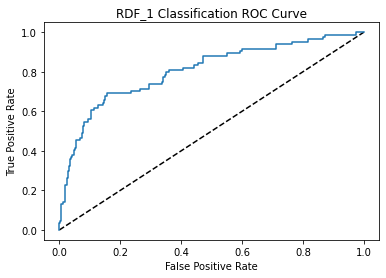

auc score: 0.8055889022275576


In [7]:
fi_mask = RDF.feature_importances_ > 0.02
X_reduced = X.loc[:, fi_mask]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)
RDF1 = RandomForestClassifier(random_state=123,max_depth=10, n_estimators=500)
RDF1.fit(X_train, y_train)
y_pred = RDF1.predict(X_test)
y_prob = RDF1.predict_proba(X_test)[:,-1]


features = X_reduced.columns
importances = RDF1.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('accuracy: ', (cf_matrix[0,0]+cf_matrix[1,1])/np.sum(cf_matrix))
print('recall: ', cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[1,0]))
print('FPR: ', cf_matrix[0,1]/(cf_matrix[0,1]+cf_matrix[1,1]))

k_fold = KFold(n_splits=10, shuffle=True, random_state=123)
score = cross_val_score(RDF1, X_train, y_train, cv=k_fold, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Random Forest Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RDF_1 Classification ROC Curve')
plt.show()

print('auc score:',roc_auc_score(y_test, y_prob))



## XGBoost

[[236   3]
 [ 34  21]]
accuracy:  0.8741496598639455
recall:  0.8740740740740741
FPR:  0.125


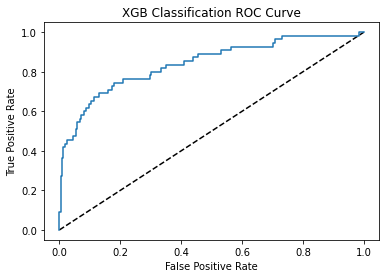

auc_score:  0.8415367059718524
cv_accuracy_score:  0.8792282726289218


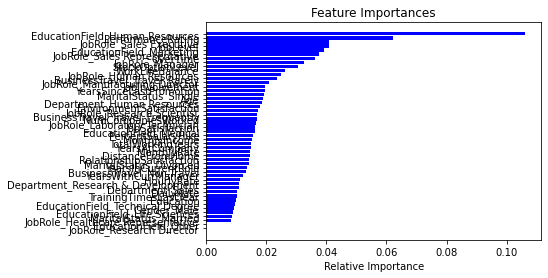

In [35]:
X=attrition_df.drop('Attrition',axis=1)
y=attrition_df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

#{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 300}
xg_cl=xgb.XGBClassifier(eval_metric='logloss',seed=10,use_label_encoder=False, objective='binary:logistic',
                       colsample_bytree=0.5, learning_rate=0.2, max_depth=8, n_estimators=300)

xg_cl.fit(X_train, y_train)
y_pred=xg_cl.predict(X_test)
y_prob = xg_cl.predict_proba(X_test)[:,1]

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('accuracy: ', (cf_matrix[0,0]+cf_matrix[1,1])/np.sum(cf_matrix))
print('recall: ', cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[1,0]))
print('FPR: ', cf_matrix[0,1]/(cf_matrix[0,1]+cf_matrix[1,1]))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='XGBClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classification ROC Curve')
plt.show()
print('auc_score: ', roc_auc_score(y_test, y_prob))

score = cross_val_score(xg_cl, X_train, y_train, cv=5, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

features = X.columns
importances = xg_cl.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [34]:
#params = {'max_depth':[3,5,8,10],
         #'learning_rate':[0.2, 0.1],
         #'colsample_bytree':[0.5, 0.6, 0.8, 1],
         #'n_estimators':[100, 200, 300]}

#grid_search = GridSearchCV(estimator=xg_cl, param_grid=params, cv=5, verbose=1, scoring='accuracy')

#grid_search.fit(X_train, y_train)

#print(grid_search.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:  1.2min finished


{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 300}


## XGBOOST Using Reduced Columns

[[232   7]
 [ 33  22]]
accuracy:  0.8639455782312925
recall:  0.8754716981132076
FPR:  0.2413793103448276


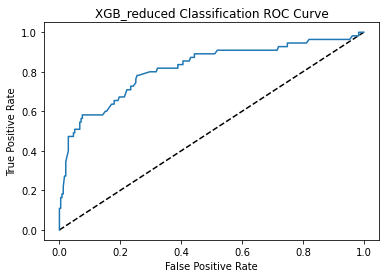

auc_score:  0.8179155572461012
cv_accuracy_score:  0.8596898665705013


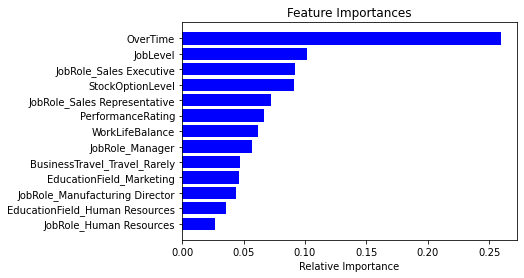

In [40]:
fi_mask = xg_cl.feature_importances_ > 0.02
X_reduced = X.loc[:, fi_mask]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=10)
#{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 100}
xg_cl1 = xgb.XGBClassifier(eval_metric='logloss', seed=10,use_label_encoder=False, objective='binary:logistic',
                          colsample_bytree=0.5, learning_rate=0.2, max_depth=8, n_estimators=100)

xg_cl1.fit(X_train, y_train)
y_pred=xg_cl1.predict(X_test)
y_prob = xg_cl1.predict_proba(X_test)[:,1]

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('accuracy: ', (cf_matrix[0,0]+cf_matrix[1,1])/np.sum(cf_matrix))
print('recall: ', cf_matrix[0,0]/(cf_matrix[0,0]+cf_matrix[1,0]))
print('FPR: ', cf_matrix[0,1]/(cf_matrix[0,1]+cf_matrix[1,1]))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='XGBClassifier_reduced')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB_reduced Classification ROC Curve')
plt.show()
print('auc_score: ', roc_auc_score(y_test, y_prob))

score = cross_val_score(xg_cl1, X_train, y_train, cv=5, scoring='accuracy')
print('cv_accuracy_score: ',score.mean())

features = X_reduced.columns
importances = xg_cl1.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [39]:
#params = {'max_depth':[3,5,8,10],
         #'learning_rate':[0.2, 0.1],
         #'colsample_bytree':[0.5, 0.6, 0.8, 1],
         #'n_estimators':[100, 200, 300]}

#grid_search = GridSearchCV(estimator=xg_cl1, param_grid=params, cv=5, verbose=1, scoring='accuracy')

#grid_search.fit(X_train, y_train)
#print(grid_search.best_params_)




Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 8, 'n_estimators': 100}


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:   52.7s finished


# K nearest neighbors

In [28]:
knn = KNeighborsClassifier(n_neighbors=5)
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8387755102040817
{'n_neighbors': 14}
KNeighborsClassifier(n_neighbors=14)


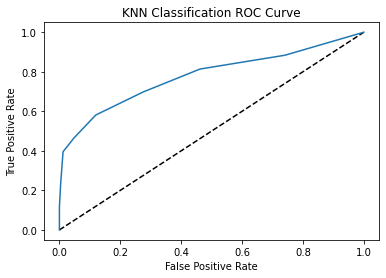

area:  0.7776799777633652
accuracy 0.8707482993197279


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=14)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='KNN Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN Classification ROC Curve')
plt.show()
print('area: ', roc_auc_score(y_test, y_prob))
print('accuracy', knn.score(X_test,y_test))

# Kernel Support Vector Machine

Gaussian Kernel

[[257   0]
 [ 37   0]]


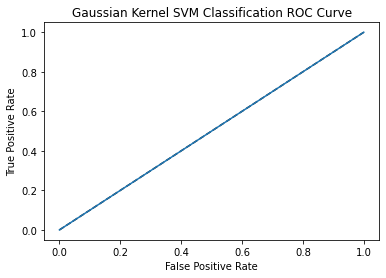

area:  0.5
accuracy 0.8741496598639455


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
from sklearn.svm import SVC
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Gaussian Kernel SVM Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gaussian Kernel SVM Classification ROC Curve')
plt.show()
print('area: ',  auc(fpr,tpr))
print('accuracy', svclassifier.score(X_test,y_test))

Sigmoid Kernel

[[248   0]
 [ 46   0]]


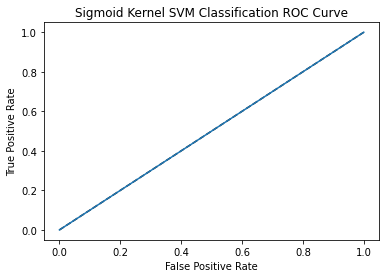

area:  0.5
accuracy 0.8435374149659864


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
from sklearn.svm import SVC
svclassifier = SVC(kernel='sigmoid')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Sigmoid Kernel SVM Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Sigmoid Kernel SVM Classification ROC Curve')
plt.show()
print('area: ', auc(fpr,tpr))
print('accuracy', svclassifier.score(X_test,y_test))

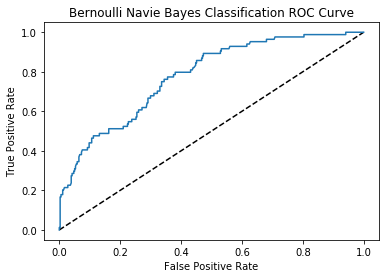

[[338  19]
 [ 57  27]]
auc_score:  0.7776610644257702
accuracy 0.8276643990929705


In [18]:
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

# redundant code
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr, label='Bernoulli Naive Bayes Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bernoulli Navie Bayes Classification ROC Curve')
plt.show()
print(confusion_matrix(y_test,y_pred))
print('auc_score: ', roc_auc_score(y_test, y_prob))
print('accuracy', clf.score(X_test,y_test))